In [22]:
# vim: set filetype=python:

# Relevance Vector Machine (RVR and RVC)

Relevance Vector Regressor and Relevance is kernelized version of ARD Regression and Classification (i.e. it uses the same algorithm for optimization but instead of applying it to raw features applies it to kernelized features).

### Development of RVM

There are three different methods for fitting Relevance Vector Machine. Tipping proposed two of them namely fixed-point iterations and expectation maximization in his original RVM paper [ Tipping(2001) ], the third one (Sequential Sparse Bayesian Learning) was discovered later by Faul and Tipping (2003). 

The version of RVM that used EM and fixed-point iterations was very slow. It was starting with all basis functions included in the model and at each iteration was removing basis functions with little explanatory power. Sparse Bayesian Learning algorithm starts with single basis function and adds new ones, so only a small subset of basis functions are used in the optimization, this gives the new version of RVM significant speed advantage over older versions.

### RVR and RVC pass scikit-learn tests for regression and classification algorithms

In [16]:
from sklearn.utils.estimator_checks import check_estimator
from skbayes.rvm_ard_models import RVR,RVC
check_estimator(RVC)
check_estimator(RVR)
print "All test are passed ..."

All test are passed ...


## Relevance Vector Regression

### Example 1: sinc(x)

RVM error on test set is 0.996854487408, number of relevant vectors is 10, time 1.27606892586
SVM error on test set is 0.997343770491, number of support vectors is 2275, time 11.461288929


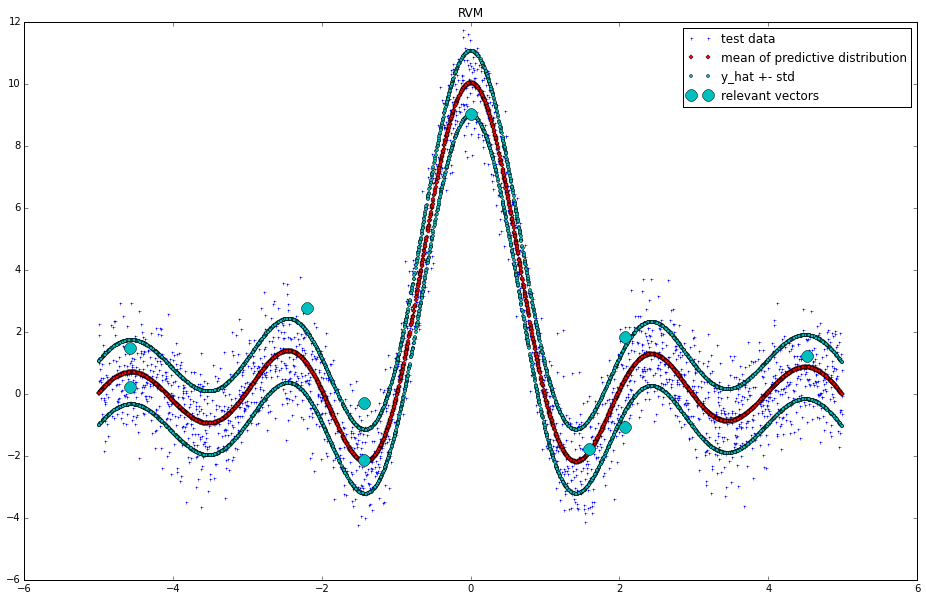

In [17]:
from sklearn.utils.estimator_checks import check_estimator
from skbayes.rvm_ard_models import RegressionARD,ClassificationARD,RVR,RVC
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error
%matplotlib inline

# parameters
n = 5000

# generate data set
np.random.seed(0)
Xc       = np.ones([n,1])
Xc[:,0]  = np.linspace(-5,5,n)
Yc       = 10*np.sinc(Xc[:,0]) + np.random.normal(0,1,n)
X,x,Y,y  = train_test_split(Xc,Yc,test_size = 0.5, random_state = 0)

# train rvr
rvm = RVR(gamma = 1,kernel = 'rbf')
t1 = time.time()
rvm.fit(X,Y)
t2 = time.time()
y_hat,var     = rvm.predict_dist(x)
rvm_err   = mean_squared_error(y_hat,y)
rvs       = np.sum(rvm.active_)
print "RVM error on test set is {0}, number of relevant vectors is {1}, time {2}".format(rvm_err, rvs, t2 - t1)

# train svr
svr = GridSearchCV(SVR(kernel = 'rbf', gamma = 1), param_grid = {'C':[0.001,0.1,1,10,100]},cv = 10)
t1 = time.time()
svr.fit(X,Y)
t2 = time.time()
svm_err = mean_squared_error(svr.predict(x),y)
svs     = svr.best_estimator_.support_vectors_.shape[0]
print "SVM error on test set is {0}, number of support vectors is {1}, time {2}".format(svm_err, svs, t2 - t1)


# plot test vs predicted data
plt.figure(figsize = (16,10))
plt.plot(x[:,0],y,"b+",markersize = 3, label = "test data")
plt.plot(x[:,0],y_hat,"rD", markersize = 3, label = "mean of predictive distribution")

# plot one standard deviation bounds
plt.plot(x[:,0],y_hat + np.sqrt(var),"co", markersize = 3, label = "y_hat +- std")
plt.plot(x[:,0],y_hat - np.sqrt(var),"co", markersize = 3)
plt.plot(rvm.relevant_vectors_,Y[rvm.active_],"co",markersize = 12,  label = "relevant vectors")
plt.legend()
plt.title("RVM")
plt.show()

Below we vizualise predictive distribution produced by Relevance Vector Regression.

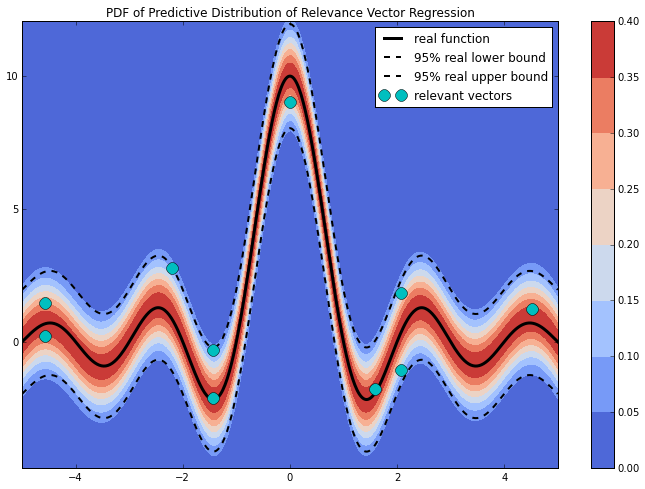

In [19]:
from scipy.stats import norm
n_grid = 500
max_x      = np.max(X,axis = 0)
min_x      = np.min(X,axis = 0)
max_y      = np.max(Y)
min_y      = np.min(Y)
X1         = np.linspace(min_x,max_x,n_grid)
Y1         = np.linspace(min_y,max_y,n_grid)
x1,y1      = np.meshgrid(X1,Y1)
Xgrid      = np.zeros([n_grid**2,2])
Xgrid[:,0] = np.reshape(x1,(n_grid**2,))
Xgrid[:,1] = np.reshape(y1,(n_grid**2,))
mu,var     = rvm.predict_dist(np.expand_dims(Xgrid[:,0],axis =1))
probs      = norm.pdf(Xgrid[:,1],loc = mu, scale = np.sqrt(var))
plt.figure(figsize = (12,8))
plt.contourf(X1,Y1,np.reshape(probs,(n_grid,n_grid)),cmap="coolwarm")
plt.plot(X1,10*np.sinc(X1),'k-',linewidth = 3, label = 'real function')
plt.plot(X1,10*np.sinc(X1)-1.96,'k-',linewidth = 2, label = '95% real lower bound',
         linestyle = '--')
plt.plot(X1,10*np.sinc(X1)+1.96,'k-',linewidth = 2, label = '95% real upper bound',
         linestyle = '--')
plt.plot(rvm.relevant_vectors_,Y[rvm.active_],"co",markersize = 12,  label = "relevant vectors")
plt.title("PDF of Predictive Distribution of Relevance Vector Regression")
plt.colorbar()
plt.legend()
plt.show()

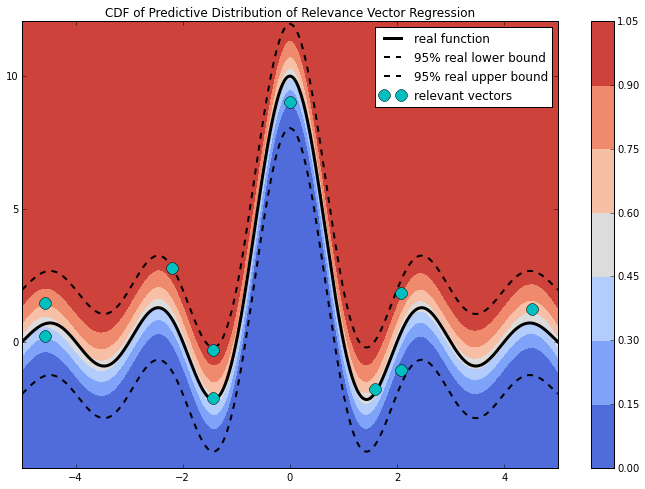

In [20]:
probs      = norm.cdf(Xgrid[:,1],loc = mu, scale = np.sqrt(var))
plt.figure(figsize = (12,8))
plt.contourf(X1,Y1,np.reshape(probs,(n_grid,n_grid)),cmap="coolwarm")
plt.plot(X1,10*np.sinc(X1),'k-',linewidth = 3, label = 'real function')
plt.plot(X1,10*np.sinc(X1)-1.96,'k-',linewidth = 2, label = '95% real lower bound',
         linestyle = '--')
plt.plot(X1,10*np.sinc(X1)+1.96,'k-',linewidth = 2, label = '95% real upper bound',
         linestyle = '--')
plt.plot(rvm.relevant_vectors_,Y[rvm.active_],"co",markersize = 12,  label = "relevant vectors")
plt.title("CDF of Predictive Distribution of Relevance Vector Regression")
plt.colorbar()
plt.legend()
plt.show()

### Example 2: Boston Housing

RVR achieves better MSE on Boston housing dataset than SVR or GBR.

In [21]:
# Boston Housing
from sklearn.datasets import load_boston
from sklearn.svm import SVR
from sklearn.preprocessing import scale
from sklearn.ensemble import GradientBoostingRegressor

boston  = load_boston()
Xb,yb   = scale(boston['data']),boston['target']
X,x,Y,y = train_test_split(Xb,yb,test_size=0.3, random_state = 0)

rvr = GridSearchCV(RVR(coef0=0.01),param_grid = {'degree':[2,3],'kernel':['rbf','poly','sigmoid'],
                                       'gamma':[0.1,1,10]})
# Polynomial kernel was not used, since SVR with 'poly' kernel 
# did not produce any results even after 30 minutes running 
# (you can try yourself!)
svr = GridSearchCV( SVR(), 
                   param_grid = {"C":np.logspace(-3,3,7),
                                 'gamma':[0.1,1,10],
                                 'kernel':['sigmoid','rbf']},
                   cv = 5)

gbr = GridSearchCV( GradientBoostingRegressor(), 
                    param_grid = {'learning_rate': [1e-3,1e-1,1],
                                  'max_depth': [1,5,10],
                                  'n_estimators':[100,500,1000]})

rvr = rvr.fit(X,Y)
svr = svr.fit(X,Y)
gbr = gbr.fit(X,Y)

In [22]:
from sklearn.metrics import mean_squared_error as mse
print " ===== Comparison of RVR -vs- SVR -vs- GBR ======"
print "\n     MSE for RVR on test set: {0} \n".format(mse(y,rvr.predict(x)))
print "\n     MSE for SVR on test set: {0} \n".format(mse(y,svr.predict(x)))
print "\n     MSE for GBR on test set: {0} \n".format(mse(y,gbr.predict(x)))


 ===== Comparison of RVR -vs- SVR -vs- GBR ======

     MSE for RVR on test set: 15.1912947255 


     MSE for SVR on test set: 15.8070855249 


     MSE for GBR on test set: 20.3440758002 



## Relevance Vector Classification

### Example 3: Binary Classification

 ====  RVC: time 0.772290229797, relevant vectors = 10 

             precision    recall  f1-score   support

          0       0.92      0.96      0.94       160
          1       0.95      0.91      0.93       140

avg / total       0.94      0.94      0.94       300

 ====  SVC: time 2.65928912163, support vectors  = 71 

             precision    recall  f1-score   support

          0       0.95      0.96      0.96       160
          1       0.96      0.94      0.95       140

avg / total       0.95      0.95      0.95       300



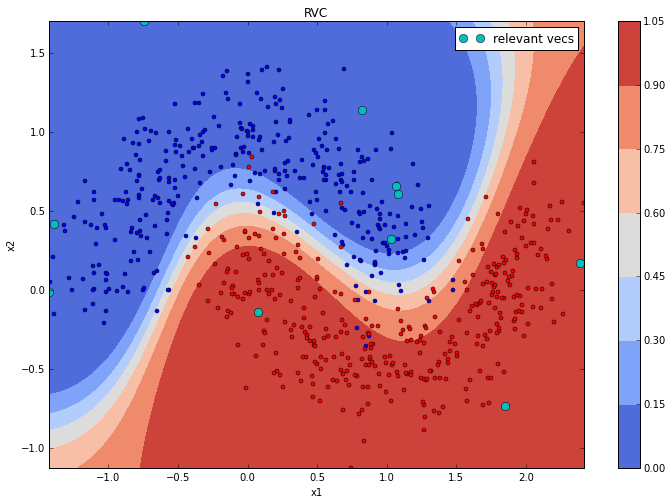

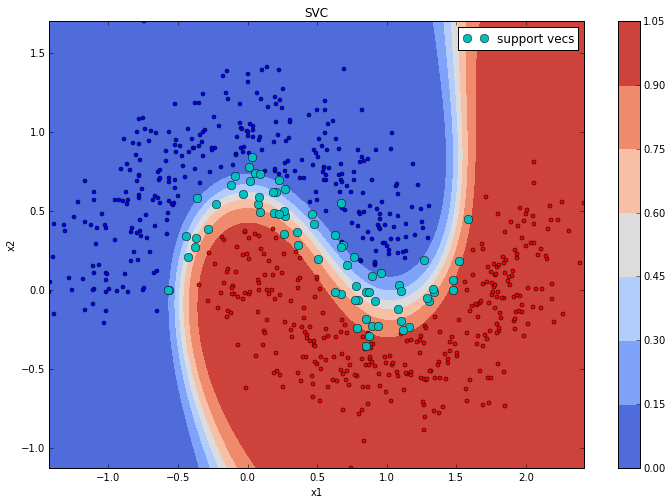

In [23]:
from sklearn.datasets import make_moons
from sklearn.metrics import classification_report
from sklearn.svm import SVC


# Parameters
n = 1000
test_proportion = 0.3

# create dataset & split into train/test parts
Xx,Yy   = make_moons(n_samples = n, noise = 0.2, random_state = 1)
X,x,Y,y = train_test_split(Xx,Yy,test_size = test_proportion, 
                                 random_state = 2)

# train rvm 
rvm = RVC(kernel = 'rbf', gamma = 1)
t1 = time.time()
rvm.fit(X,Y)
t2 = time.time()
rvm_time = t2 - t1


# train svm (and find best parameters through cross-validation)
svc = GridSearchCV(SVC(probability = True), param_grid = {"C":np.logspace(-3,3,9)}, cv = 10)
t1 = time.time()
svc.fit(X,Y)
t2 = time.time()
svm_time = t2 - t1

# report on performance
svecs = svc.best_estimator_.support_vectors_.shape[0]
rvecs = np.sum(rvm.active_[0]==True)
rvm_message = " ====  RVC: time {0}, relevant vectors = {1} \n".format(rvm_time,rvecs)
print rvm_message
print classification_report(y,rvm.predict(x))
svm_message = " ====  SVC: time {0}, support vectors  = {1} \n".format(svm_time,svecs)
print svm_message
print classification_report(y,svc.predict(x))

# create grid
n_grid = 500
max_x      = np.max(X,axis = 0)
min_x      = np.min(X,axis = 0)
X1         = np.linspace(min_x[0],max_x[0],n_grid)
X2         = np.linspace(min_x[1],max_x[1],n_grid)
n_grid = 500
max_x      = np.max(X,axis = 0)
min_x      = np.min(X,axis = 0)
X1         = np.linspace(min_x[0],max_x[0],n_grid)
X2         = np.linspace(min_x[1],max_x[1],n_grid)
x1,x2      = np.meshgrid(X1,X2)
Xgrid      = np.zeros([n_grid**2,2])
Xgrid[:,0] = np.reshape(x1,(n_grid**2,))
Xgrid[:,1] = np.reshape(x2,(n_grid**2,))

sv_grid = svc.predict_proba(Xgrid)[:,1]
rv_grid = rvm.predict_proba(Xgrid)[:,1]
models  = [rv_grid,sv_grid]
model_names = ["RVC","SVC"]

for model, model_name in zip(models, model_names):
    plt.figure(figsize = (12,8))
    plt.contourf(X1,X2,np.reshape(model,(n_grid,n_grid)),
                       cmap="coolwarm",
                       figsize = (10,16))
    plt.colorbar()
    plt.plot(X[Y==0,0],X[Y==0,1],"bo", markersize = 4)
    plt.plot(X[Y==1,0],X[Y==1,1],"ro", markersize = 4)
    # plot 'support' or 'relevant' vectors
    svrv = None
    point_label = None
    if model_name == "SVC":
        svrv = svc.best_estimator_.support_vectors_
        point_label = "support vecs"
    else:
        svrv = rvm.relevant_vectors_[0]
        point_label = "relevant vecs"
    plt.plot(svrv[:,0],svrv[:,1],'co',markersize=8,label=point_label)
    plt.plot()
    title = model_name
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.show()

### Example 4: Multiclass classification

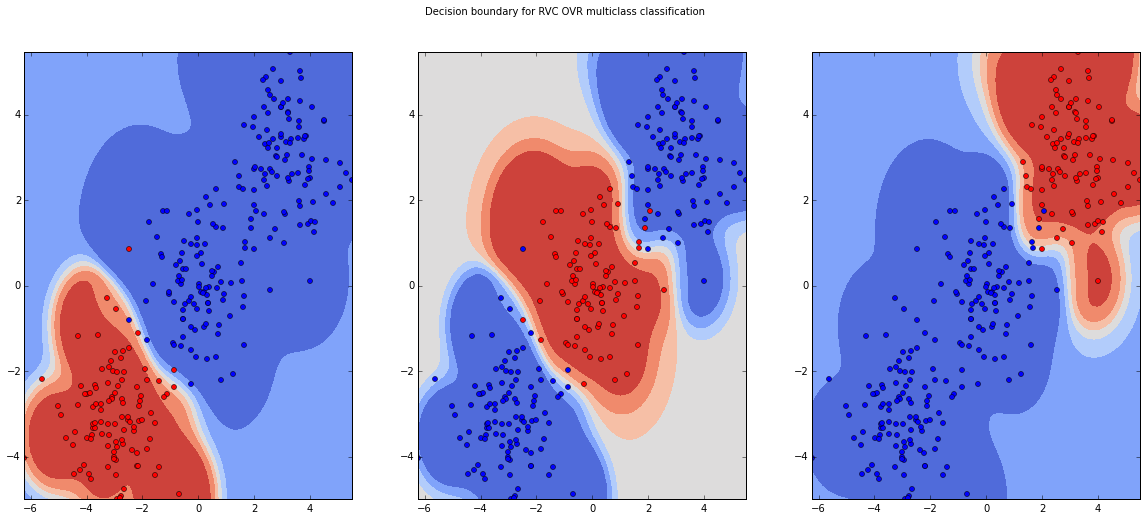

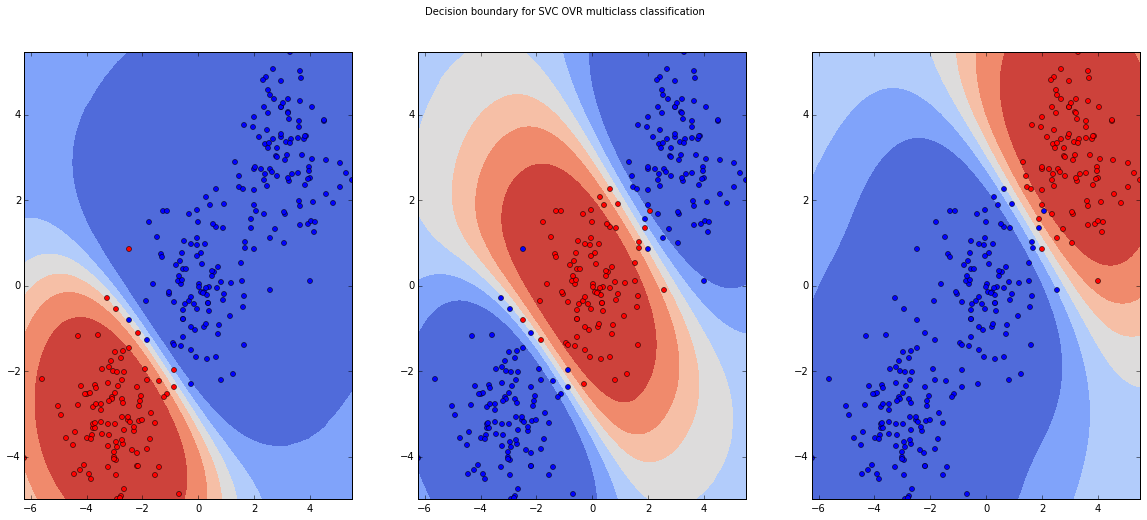

             precision    recall  f1-score   support

          0       0.99      0.98      0.99       106
          1       0.97      0.95      0.96        96
          2       0.96      0.99      0.97        98

avg / total       0.97      0.97      0.97       300

             precision    recall  f1-score   support

          0       0.99      0.98      0.99       106
          1       0.97      0.97      0.97        96
          2       0.98      0.99      0.98        98

avg / total       0.98      0.98      0.98       300



In [25]:
from sklearn.datasets import make_blobs
from sklearn.metrics import classification_report
from matplotlib import cm
centers = [(-3, -3), (0, 0), (3, 3)]
n_samples = 600

# create training & test set
X, y = make_blobs(n_samples=n_samples, n_features=2, cluster_std=1.0,
                  centers=centers, shuffle=False, random_state=42)
X, x, Y, y = train_test_split(X, y, test_size=0.5, random_state=42)

# fit rvc & svc
rvm = RVC(gamma = 1, kernel = 'rbf')
rvm.fit(X,Y)
svc = GridSearchCV(SVC(kernel = 'rbf', degree = 2, probability = True), 
                   param_grid = {"C":np.logspace(-3,3,7),
                                 "gamma":[0.1,1,10]},
                   cv = 10)
svc.fit(X,Y)

# create grid
n_grid = 100
max_x      = np.max(x,axis = 0)
min_x      = np.min(x,axis = 0)
X1         = np.linspace(min_x[0],max_x[0],n_grid)
X2         = np.linspace(min_x[1],max_x[1],n_grid)
x1,x2      = np.meshgrid(X1,X2)
Xgrid      = np.zeros([n_grid**2,2])
Xgrid[:,0] = np.reshape(x1,(n_grid**2,))
Xgrid[:,1] = np.reshape(x2,(n_grid**2,))


rv_grid = rvm.predict_proba(Xgrid)
sv_grid = svc.predict_proba(Xgrid)
grids   = [rv_grid, sv_grid]
names   = ['RVC','SVC']
classes = np.unique(y)

# plot heatmaps
for grid,name in zip(grids,names):
    fig, axarr = plt.subplots(nrows=1, ncols=3, figsize = (20,8))
    for ax,cl,model in zip(axarr,classes,grid.T):
        ax.contourf(x1,x2,np.reshape(model,(n_grid,n_grid)),cmap=cm.coolwarm)
        ax.plot(x[y==cl,0],x[y==cl,1],"ro", markersize = 5)
        ax.plot(x[y!=cl,0],x[y!=cl,1],"bo", markersize = 5)
    plt.suptitle(' '.join(['Decision boundary for',name,'OVR multiclass classification']))
    plt.show()
    
print classification_report(y,rvm.predict(x))
print classification_report(y,svc.predict(x))


### Example: Pima Indians Diabetes dataset

In this example, we test Relevance Vector Classifier against SVC and Random Forest Classifier on a real dataset. Classification reports below show that RVC performs better than SVC and achieves almost the same results as RFC.

P.S.: For some reason (numerical issues probably) SVC with polynomial kernel did not run, so we used only other kernels.

In [26]:
import pandas as pd
data = np.array(pd.read_csv('pima-indians-diabetes.data.csv', header = None))
X,x,Y,y = train_test_split(data[:,:-1],data[:,-1], test_size = 0.2, random_state=1)

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

rvc = GridSearchCV(RVC(kernel = 'poly'),param_grid = {'degree':[2,3],
                                                      'gamma':[1e-2,1e-1,1,1e+1],
                                                      'coef0':[0.1,1,10]})
# Polynomial kernel was not used, since SVC with 'poly' kernel 
# did not produce any results even after 30 minutes running 
# (you can try yourself!)
svc = GridSearchCV(SVC(probability = True), 
                   param_grid = {"C":np.logspace(-3,3,7),
                                 'gamma':[0.1,1,10],
                                 'kernel':['sigmoid','rbf']},
                   cv = 5)

gbc = GridSearchCV( RandomForestClassifier(n_estimators = 1000), 
                    param_grid = {'max_depth': [1,5,10]})

rvc.fit(X,Y)
svc.fit(X,Y)
gbc.fit(X,Y)
print "\n      === Relevance Vector Classifier === \n"
print classification_report(y,rvc.predict(x))
print "\n      === Support Vector Classifier === \n"
print classification_report(y,svc.predict(x))
print "\n      === Gradient Boosting Classifier === \n"
print classification_report(y,gbc.predict(x))


      === Relevance Vector Classifier === 

             precision    recall  f1-score   support

        0.0       0.76      0.95      0.85        99
        1.0       0.84      0.47      0.60        55

avg / total       0.79      0.78      0.76       154


      === Support Vector Classifier === 

             precision    recall  f1-score   support

        0.0       0.64      1.00      0.78        99
        1.0       0.00      0.00      0.00        55

avg / total       0.41      0.64      0.50       154


      === Gradient Boosting Classifier === 

             precision    recall  f1-score   support

        0.0       0.80      0.89      0.84        99
        1.0       0.75      0.60      0.67        55

avg / total       0.78      0.79      0.78       154



/Users/amazaspshaumyan/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
